In [200]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import time

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [202]:
data = pd.read_csv('GOOGL.csv')
data = data['Open']

In [203]:
print(data.shape)

(3702,)


## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [204]:
scaler = MinMaxScaler()
x = scaler.fit_transform(data.values.reshape((-1,1)))

In [205]:
print(x)

[[3.27076291e-04]
 [7.34916593e-04]
 [4.66793067e-03]
 ...
 [9.26081632e-01]
 [9.05992468e-01]
 [9.09873189e-01]]


# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [206]:
import copy
def batch_generator(data, batch_size,num_seq):
    data1 = copy.deepcopy(data)
    # generate sequence
    x_s = []
    y_s = []
    for i in range(len(data1)-num_seq):
        x_s.append(data1[i:i+num_seq])
        y_s.append(data1[i+num_seq])
        
    # generate batch    
    start_idx = 0
    end_idx = batch_size
    while end_idx < len(data):
        x = np.reshape(x_s[start_idx:end_idx],(batch_size,num_seq,1))
        y = np.reshape(y_s[start_idx:end_idx],(batch_size,1))
        yield(x,y)
        start_idx += batch_size
        end_idx += batch_size

In [209]:
a = int(len(data)*0.8)
b = int(len(data)*0.9)
train_data,val_data,test_data = x[:a],x[a:b],x[b:]


In [210]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(2961, 1)
(370, 1)
(371, 1)


# TesnorFlow Model

In [229]:
epoch = 2000
#unrolled through 8 time steps
num_seq=8
#hidden LSTM units
num_units=256
# each cell input 1 
input_size=1
output_size = 1
#learning rate for adam
learning_rate=0.005

#size of batch
batch_size=256

keep_prob = 0.5


In [230]:
tf.reset_default_graph()

In [231]:
X = tf.placeholder(tf.float64,[None,num_seq,input_size],name='X')
Y = tf.placeholder(tf.float64,[None,output_size],name='Y')

In [232]:
def lstm(X):
    lstm_cell=tf.contrib.rnn.BasicLSTMCell(num_units,forget_bias=0.8)
    lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
    initial_state = lstm_cell.zero_state(batch_size,dtype=tf.float64)
    #  output shape :[batch_size, num_seq, cell.output_size] final_state: [batch_size, cell.output_size]
    outputs,final_state = tf.nn.dynamic_rnn(cell = lstm_cell, inputs = X, initial_state = initial_state,dtype="float64")
    return outputs

In [233]:
Y_pred = tf.contrib.layers.fully_connected(lstm(X)[:,-1,:],output_size)
#loss_function
# loss=tf.losses.mean_squared_error(Y,Y_pred)
loss = tf.reduce_sum(tf.square(Y-Y_pred))
#optimization
opt=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)


# Training

In [234]:
from tqdm import tqdm
epoch_list = []
train_loss_list = []
val_loss_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1,epoch+1):
        #fetch batch
        training_data = batch_generator(train_data, batch_size,num_seq)
        for t_data, labels in training_data:
            f_dict = {X: t_data, Y: labels}
            sess.run(opt, feed_dict=f_dict)
                
        if(i%10 == 0):
            epoch_list.append(i)
            
            val_loss = 0
            validation_data = batch_generator(val_data, batch_size,num_seq)
            for v_data, labels in validation_data:
                f_dict = {X: v_data, Y: labels}
                val_loss += sess.run(loss, feed_dict=f_dict)
            val_loss /=len(val_data)
            val_loss_list.append(val_loss)
            #print('Epoch'+str(i),"validation loss= {:.10f}".format(val_loss))
    
    
    print("Training finished!")



Training finished!


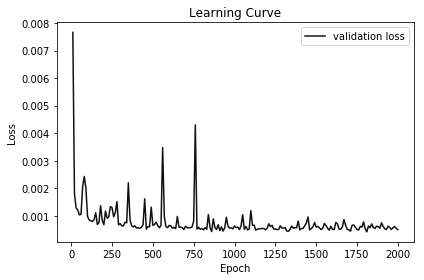

In [235]:
# Draw lines
# plt.plot(epoch_list,train_loss_list,  '--', color="#111111",  label="Training loss")
plt.plot(epoch_list,val_loss_list,  color="#111111", label="validation loss")


# Create plot
plt.title("Learning Curve")
plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()



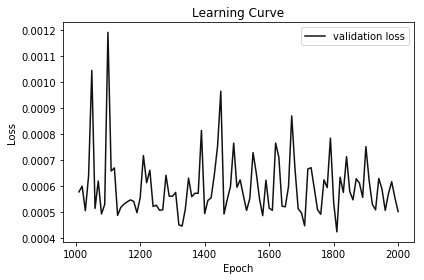

In [237]:
plt.plot(epoch_list[100:],val_loss_list[100:],  color="#111111", label="validation loss")


# Create plot
plt.title("Learning Curve")
plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Testing

In [238]:
prediction = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1,2000):
        #fetch batch
        training_data = batch_generator(train_data, batch_size,num_seq)
        for t_data, labels in training_data:
            f_dict = {X: t_data, Y: labels}
            sess.run(opt, feed_dict=f_dict)
        
    testing_data = batch_generator(test_data, batch_size,num_seq)
    for tt_data, labels in testing_data:
        f_dict = {X: tt_data, Y: labels}
        prediction.append(sess.run(Y_pred, feed_dict=f_dict))


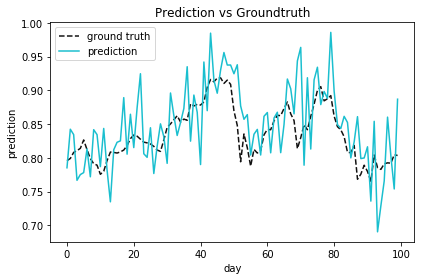

In [239]:
# Draw lines
plt.plot(test_data[num_seq-1:100+num_seq-1],  '--', color="#111111",  label="ground truth")
plt.plot(prediction[0][:100],  color="#1ABFCF", label="prediction")


# Create plot
plt.title("Prediction vs Groundtruth")
plt.xlabel("day"), plt.ylabel("prediction"), plt.legend(loc="best")
plt.tight_layout()
plt.show()